# Analyze RNA tetramers (repx)

### TODO
- add inner minor ticks
- change xtick range to 0 - 360 for backbone torsion plot
- optimize definition to categorize structures

In [1]:
import os, sys, math
import numpy as np
import glob
import mdtraj
import logging
import netCDF4 as nc
import warnings
import pandas as pd
#from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns

import openmmtools as mmtools
from pymbar import timeseries
from openmm import *
from openmm.app import *
#from openmm.unit import *   # don't use this! builtin_function_or_method sum is used in extract_trajectory

import barnaba as bb
from barnaba import definitions
from barnaba.nucleic import Nucleic

In [2]:
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

In [4]:
#plt.rcParamsDefault

In [5]:
params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [6]:
backbone_sugar_atoms = [
    "C1'", \
    "H1'", \
    "C2'", \
    "H2'", \
    "C3'", \
    "H3'", \
    "C4'", \
    "H4'", \
    "C5'", \
    "H5'", \
    "H5''", \
    "O2'", \
    "HO2'", \
    "O3'", \
    "O4'", \
    "O5'", \
    "P", \
    "OP1", \
    "OP2", \
    "HO5'", \
    "HO3'"
]

In [7]:
backbone_annot_dict = {}
backbone_annot_dict["alpha"]=0
backbone_annot_dict["beta"]=1
backbone_annot_dict["gamma"]=2
backbone_annot_dict["delta"]=3
backbone_annot_dict["eps"]=4
backbone_annot_dict["zeta"]=5
backbone_annot_dict["chi"]=6

In [8]:
def radian_to_degree(a):
    """
    a : list
        [trajectory frame : residue : torsion]
    """
    
    a[np.where(a<0.0)] += 2.*np.pi
    a *= 180.0/np.pi

    # same as above
    #a = a*(180./np.pi)
    #a[np.where(a<0.0)] += 360
    
    return a

In [9]:
# ==============================================================================
# Extract trajectory from NetCDF4 file
# https://github.com/choderalab/yank/blob/master/Yank/analyze.py
# ==============================================================================

def extract_trajectory(reference, nc_path, nc_checkpoint_file=None, checkpoint_interval=50, state_index=None, replica_index=None,
                       start_frame=0, end_frame=-1, skip_frame=1, keep_solvent=True,
                       discard_equilibration=False):
    """Extract phase trajectory from the NetCDF4 file.
    Parameters
    ----------
    reference : str
        Path to reference pdb file
    nc_path : str
        Path to the primary nc_file storing the analysis options
    nc_checkpoint_file : str or None, Optional
        File name of the checkpoint file housing the main trajectory
        Used if the checkpoint file is differently named from the default one chosen by the nc_path file.
        Default: None
    checkpoint_interval : int >= 1, Default: 50
        The frequency at which checkpointing information is written relative to analysis information.
        This is a multiple
        of the iteration at which energies is written, hence why it must be greater than or equal to 1.
        Checkpoint information cannot be written on iterations which where ``iteration % checkpoint_interval != 0``.
    state_index : int, optional
        The index of the alchemical state for which to extract the trajectory.
        One and only one between state_index and replica_index must be not None
        (default is None).
    replica_index : int, optional
        The index of the replica for which to extract the trajectory. One and
        only one between state_index and replica_index must be not None (default
        is None).
    start_frame : int, optional
        Index of the first frame to include in the trajectory (default is 0).
    end_frame : int, optional
        Index of the last frame to include in the trajectory. If negative, will
        count from the end (default is -1).
    skip_frame : int, optional
        Extract one frame every skip_frame (default is 1).
    keep_solvent : bool, optional
        If False, solvent molecules are ignored (default is True).
    discard_equilibration : bool, optional
        If True, initial equilibration frames are discarded (see the method
        pymbar.timeseries.detectEquilibration() for details, default is False).
    Returns
    -------
    trajectory: mdtraj.Trajectory
        The trajectory extracted from the netcdf file.
    """
    # Check correct input
    if (state_index is None) == (replica_index is None):
        raise ValueError('One and only one between "state_index" and '
                         '"replica_index" must be specified.')
    if not os.path.isfile(nc_path):
        raise ValueError('Cannot find file {}'.format(nc_path))

    # Import simulation data
    reporter = None
    try:
        reporter = mmtools.multistate.MultiStateReporter(nc_path, open_mode='r', checkpoint_storage=nc_checkpoint_file, checkpoint_interval=checkpoint_interval)
        reference = mdtraj.load_pdb(reference)
        topology = reference.topology
        
        # Get dimensions
        # Assume full iteration until proven otherwise
        last_checkpoint = True
        trajectory_storage = reporter._storage_checkpoint
        if not keep_solvent:
            # If tracked solute particles, use any last iteration, set with this logic test
            full_iteration = len(reporter.analysis_particle_indices) == 0
            if not full_iteration:
                trajectory_storage = reporter._storage_analysis
                topology = topology.subset(reporter.analysis_particle_indices)

        n_iterations = reporter.read_last_iteration(last_checkpoint=last_checkpoint)
        n_frames = trajectory_storage.variables['positions'].shape[0]
        n_atoms = trajectory_storage.variables['positions'].shape[2]
        logger.info('Number of frames: {}, atoms: {}'.format(n_frames, n_atoms))

        # Determine frames to extract.
        # Convert negative indices to last indices.
        if start_frame < 0:
            start_frame = n_frames + start_frame
        if end_frame < 0:
            end_frame = n_frames + end_frame + 1
        frame_indices = range(start_frame, end_frame, skip_frame)
        if len(frame_indices) == 0:
            raise ValueError('No frames selected')
        logger.info('Extracting frames from {} to {} every {}'.format(start_frame, end_frame, skip_frame))

        # Discard equilibration samples
        if discard_equilibration:
            u_n = extract_u_n(reporter._storage_analysis)
            # Discard frame 0 with minimized energy which throws off automatic equilibration detection.
            n_equil_iterations, g, n_eff = timeseries.detectEquilibration(u_n[1:])
            n_equil_iterations += 1
            logger.info(("Discarding initial {} equilibration samples (leaving {} "
                         "effectively uncorrelated samples)...").format(n_equil_iterations, n_eff))
            # Find first frame post-equilibration.
            if not full_iteration:
                for iteration in range(n_equil_iterations, n_iterations):
                    n_equil_frames = reporter._calculate_checkpoint_iteration(iteration)
                    if n_equil_frames is not None:
                        break
            else:
                n_equil_frames = n_equil_iterations
            frame_indices = frame_indices[n_equil_frames:-1]
        else:
            logging.info("Discard automatic equilibration detection")

        # Determine the number of frames that the trajectory will have.
        if state_index is None:
            n_trajectory_frames = len(frame_indices)
        else:
            # With SAMS, an iteration can have 0 or more replicas in a given state.
            # Deconvolute state indices.
            state_indices = [None for _ in frame_indices]
            for i, iteration in enumerate(frame_indices):
                replica_indices = reporter._storage_analysis.variables['states'][iteration, :]
                state_indices[i] = np.where(replica_indices == state_index)[0]
                #print(state_index, replica_indices, np.where(replica_indices == state_index)[0])
            n_trajectory_frames = sum(len(x) for x in state_indices)

        # Initialize positions and box vectors arrays.
        # MDTraj Cython code expects float32 positions.
        positions = np.zeros((n_trajectory_frames, n_atoms, 3), dtype=np.float32)
        box_vectors = np.zeros((n_trajectory_frames, 3, 3), dtype=np.float32)

        # Extract state positions and box vectors.
        if state_index is not None:
            logger.info('Extracting positions of state {}...'.format(state_index))

            # Extract state positions and box vectors.
            frame_idx = 0
            for i, iteration in enumerate(frame_indices):
                for replica_index in state_indices[i]:
                    positions[frame_idx, :, :] = trajectory_storage.variables['positions'][iteration, replica_index, :, :].astype(np.float32)
                    box_vectors[frame_idx, :, :] = trajectory_storage.variables['box_vectors'][iteration, replica_index, :, :].astype(np.float32)
                    frame_idx += 1

        else:  # Extract replica positions and box vectors
            logger.info('Extracting positions of replica {}...'.format(replica_index))

            for i, iteration in enumerate(frame_indices):
                positions[i, :, :] = trajectory_storage.variables['positions'][iteration, replica_index, :, :].astype(np.float32)
                box_vectors[i, :, :] = trajectory_storage.variables['box_vectors'][iteration, replica_index, :, :].astype(np.float32)
    finally:
        if reporter is not None:
            reporter.close()

    # Create trajectory object
    logger.info('Creating trajectory object...')
    trajectory = mdtraj.Trajectory(positions, topology)
    trajectory.unitcell_vectors = box_vectors

    return trajectory

# Define paramters

In [10]:
PLOT_TITLE = "CCCC Amber ff14"
UNIT_NM_TO_ANGSTROMS = 10
UNIT_PS_TO_NS = 1/1000

#### trajectory files

In [11]:
basepath = "../../../../"

# initial structure
init_pdb = os.path.join(basepath, "eq/solvated.pdb")

# reference structure
ref_pdb = os.path.join(basepath, "eq/min.pdb")
ref_traj = mdtraj.load(ref_pdb)

# equilibrated
eq_ncfile = os.path.join(basepath, "eq/traj.nc")
eq_traj = mdtraj.load(eq_ncfile, top=init_pdb)

# enhanced
ncfiles = glob.glob("../*/enhanced.nc")
ncfiles.sort()
print(ncfiles)

['../1/enhanced.nc', '../2/enhanced.nc', '../3/enhanced.nc', '../4/enhanced.nc', '../5/enhanced.nc']


In [12]:
# parameters to read repx trajectories
CHECKPOINT_INTERVAL = 50
START_FRAME = 1
END_FRAME = -1
SKIP_FRAME = 1
DISCARD_EQUILIBRATION=False

#### check number of states and replicas

In [13]:
# reporter
reporter = mmtools.multistate.MultiStateReporter(ncfiles[0], open_mode='r')
n_states = reporter.n_states
n_replicas = reporter.n_replicas

print("n_states: {}".format(n_states))
print("n_replicas: {}".format(n_replicas))

n_states: 10
n_replicas: 10


#### residue names

In [14]:
rnames = [ residue.name for residue in ref_traj.topology.residues if residue.name not in ["HOH", "NA", "CL"]]
print(rnames)

['C', 'C', 'C', 'C']


# Load trajectories and calculate properties

In [99]:
bb_angles = []
pucker_angles = []
rg = []
rmsd, ermsd = [], []
stackings = []
dist1, dist2, dist3 = [], [], []
couplings = []

for ncfile in ncfiles:
    for i in range(n_states):    
        #print(i)
        t = extract_trajectory(reference=init_pdb, nc_path=ncfile, start_frame=START_FRAME, end_frame=END_FRAME, skip_frame=SKIP_FRAME, state_index=i, discard_equilibration=DISCARD_EQUILIBRATION)
        
        # backbone angles
        _angles, _res = bb.backbone_angles_traj(t)
        bb_angles.append(_angles)
        
        # suger pucker angles
        _angles, _res = bb.pucker_rao_traj(t)
        pucker_angles.append(_angles)
        
        # radius of gyration
        atom_indices = t.topology.select('not (protein or water or symbol Na or symbol Cl)')
        _t = t.atom_slice(atom_indices)
        rg.append(mdtraj.compute_rg(_t))
        
        # rmsd
        _rmsd = list(bb.functions.rmsd_traj(ref_traj, t))
        rmsd.append(_rmsd)
        
        # ermsd
        _ermsd = list(bb.functions.ermsd_traj(ref_traj, t))   
        ermsd.append(_ermsd)
        
        # annotation
        _stackings, _pairings, _res = bb.annotate_traj(t)
        stackings.append(_stackings)
        
        # N1 distance
        atom_indices = t.topology.select('name N1')
        # distance between first (5'-end) and second N1 atom
        _dist1 = mdtraj.compute_distances(t, atom_pairs=atom_indices[:2].reshape(1,2))
        dist1.append(_dist1)
        # distance between second and third (3'-end) N1 atom
        _dist2 = mdtraj.compute_distances(t, atom_pairs=atom_indices[1:3].reshape(1,2))
        dist2.append(_dist2)
        # distance between third and fourth (3'-end) N1 atom
        _dist3 = mdtraj.compute_distances(t, atom_pairs=atom_indices[2:].reshape(1,2))
        dist3.append(_dist3)
        
        # jcoupling
        _couplings, _res = bb.jcouplings_traj(t, couplings=["H1H2", "H2H3", "H3H4", "1H5P", "2H5P", "1H5H4", "2H5H4", "H3P"] )
        couplings.append(_couplings)

# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


# found  45 atoms in common


other candidates

#### concatenate or flatten

In [100]:
bb_angles = np.concatenate(bb_angles)
pucker_angles = np.concatenate(pucker_angles)
rg = np.concatenate(rg) * UNIT_NM_TO_ANGSTROMS
rmsd = np.array(rmsd).flatten() * UNIT_NM_TO_ANGSTROMS
ermsd = np.array(ermsd).flatten() * UNIT_NM_TO_ANGSTROMS
stackings = np.concatenate(stackings)
dist1 = np.concatenate(dist1) * UNIT_NM_TO_ANGSTROMS
dist2 = np.concatenate(dist2) * UNIT_NM_TO_ANGSTROMS
dist3 = np.concatenate(dist3) * UNIT_NM_TO_ANGSTROMS
couplings = np.concatenate(couplings)

#### convert radian to degree

In [101]:
pucker_angles_radian = np.copy(pucker_angles)

In [103]:
bb_angles = radian_to_degree(bb_angles) # alpha, beta, gamma, delta, eps, zeta, chi
pucker_angles = radian_to_degree(pucker_angles)  # phase, amplitude

In [105]:
assert bb_angles.shape[0] == pucker_angles.shape[0] == rg.shape[0] == rmsd.shape[0] == ermsd.shape[0] == stackings.shape[0] == dist1.shape[0] == dist2.shape[0] == dist3.shape[0], \
print(bb_angles.shape, pucker_angles.shape, rg.shape, rmsd.shape, ermsd.shape, stackings.shape, dist1.shape, dist2.shape, dist3.shape)

#### save

In [106]:
np.savez("mydata.npz", bb_angles=bb_angles, pucker_angles=pucker_angles, rg=rg, rmsd=rmsd, ermsd=ermsd, stackings=stackings, n1_dist=[dist1, dist2, dist3], couplings=couplings)

#npzfile = np.load(outfile)
#npzfile["bb_angles"]

# Torsion distribution

In [107]:
cols = []
#cols.append("Residue")
cols += [ a for a in definitions.bb_angles ]

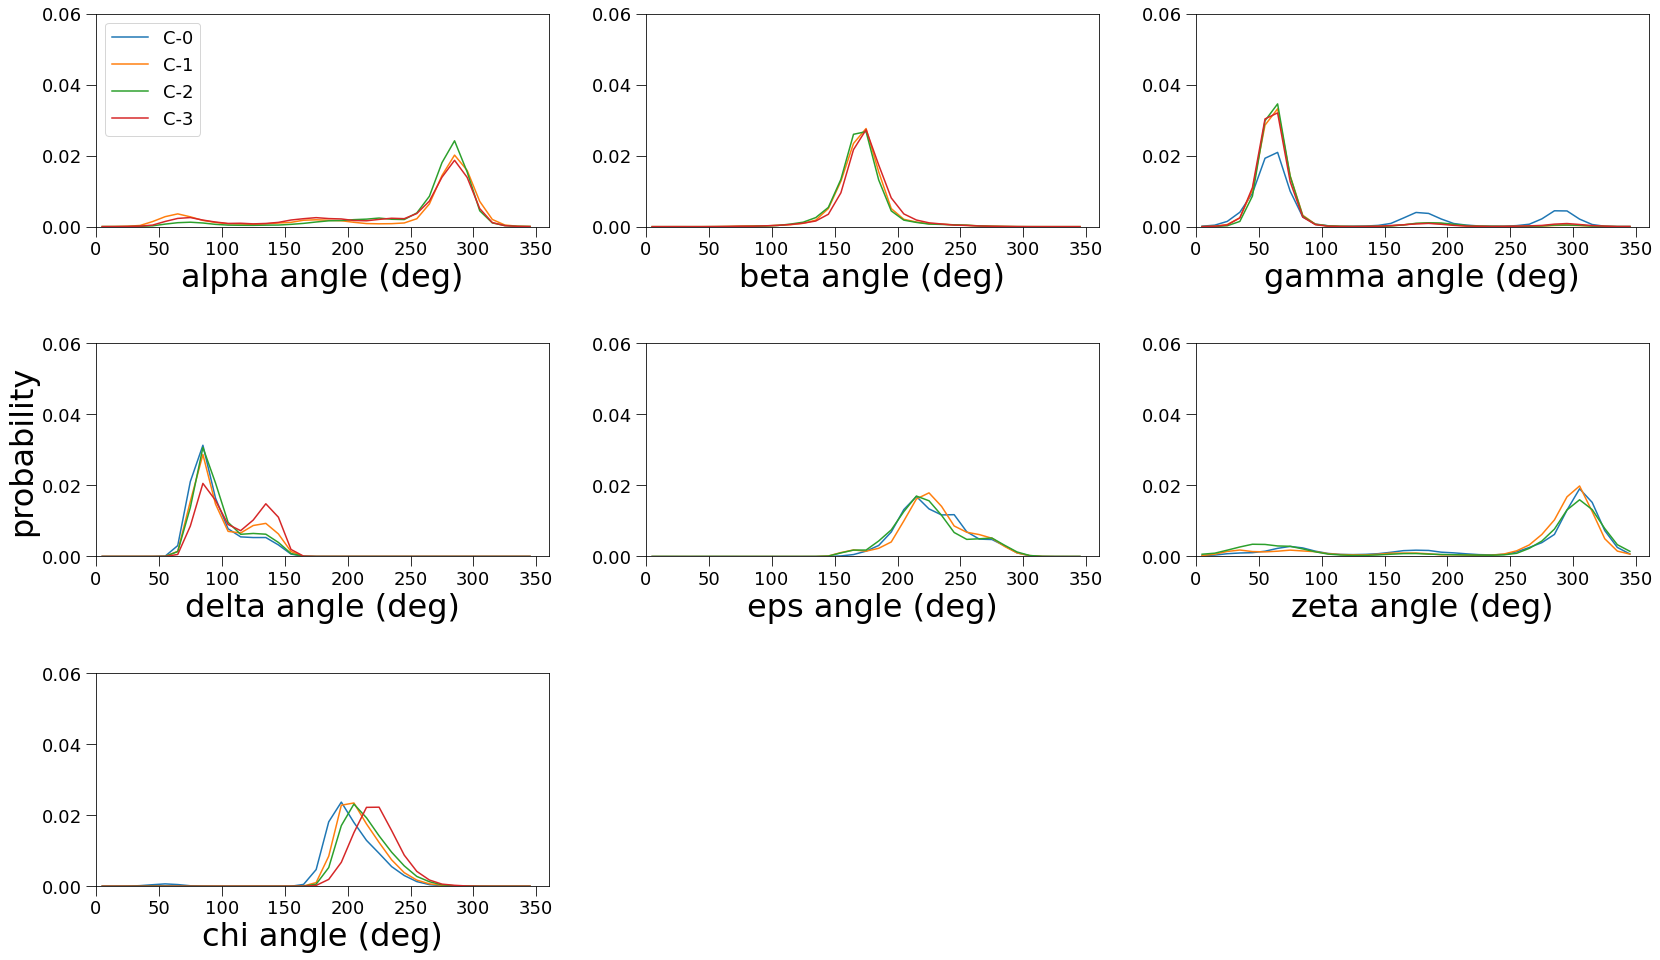

In [108]:
# create historgram 
bins = np.arange(0, 360, 10)

# make plot
fig = plt.figure(figsize=(24,18))
for k, v in backbone_annot_dict.items():
    """
    k : torsion name
    v : torsion index
    """
    ax = fig.add_subplot(4, 3, v+1)
    for i in range(len(rnames)):
        """
        i : residue name index
        x : normalized frequency
        y : degree
        """
        y, x = np.histogram(bb_angles[:,i, v], density=True, bins=bins)
        ax.plot(0.5*(x[1:]+x[:-1]), y, label="{}-{}".format(rnames[i], i))
    if v == 0:
        plt.legend(loc="upper left", fontsize=18)
    if v == 3:
        ax.set_ylabel("probability", fontsize=32)
    ax.set_xlabel("{} angle (deg)".format(k), fontsize=32)
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 0.06)
    ax.tick_params(axis='both', labelsize=18)
    #plt.text(60, 0.005, "syn", fontsize=18, ha='center')
    #plt.text(190, 0.005, "anti", fontsize=18, ha='center')
    #plt.text(260, 0.005, "high-anti", fontsize=18, ha='center')

plt.tight_layout()
plt.savefig("bb_angles.png")

#### sugar pucker

In [109]:
# initial structure
init_angles, res = bb.pucker_angles(init_pdb, topology=init_pdb)

# Loading ../../../../eq/solvated.pdb 


<Figure size 4608x576 with 0 Axes>

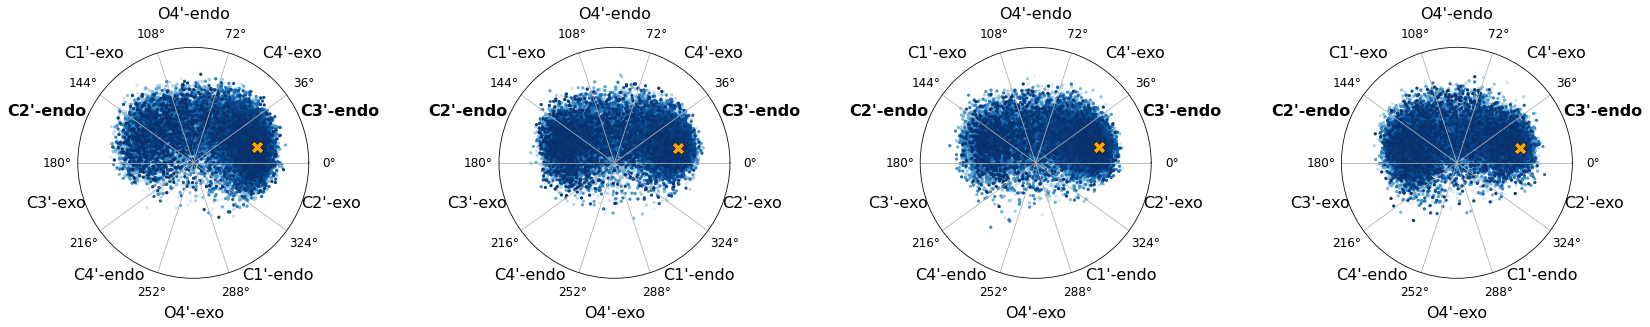

In [111]:
# make plot
plt.clf()
fig = plt.figure(figsize=(24,18))
for i in range(len(rnames)):
    ax = fig.add_subplot(1, 4, i+1, polar=True)
    #ax.plot(polar=True)

    ax.scatter(pucker_angles_radian[:,i,0], pucker_angles_radian[:,i,1], s=5, c=np.arange(len(pucker_angles_radian)), cmap='Blues', label="{}-{}".format(rnames[i], i))
    ax.scatter(init_angles[:,i,0], init_angles[:,i,1], marker="X", c="orange", edgecolors="black", s=150, linewidths=0.5)
    
    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)
    
    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    #plt.legend(loc="upper center")
    plt.savefig("pucker_anlges.png")

# Radius of gyration

In [117]:
print(rg.max(), rg.min())

8.485098488861082 4.82958304152328


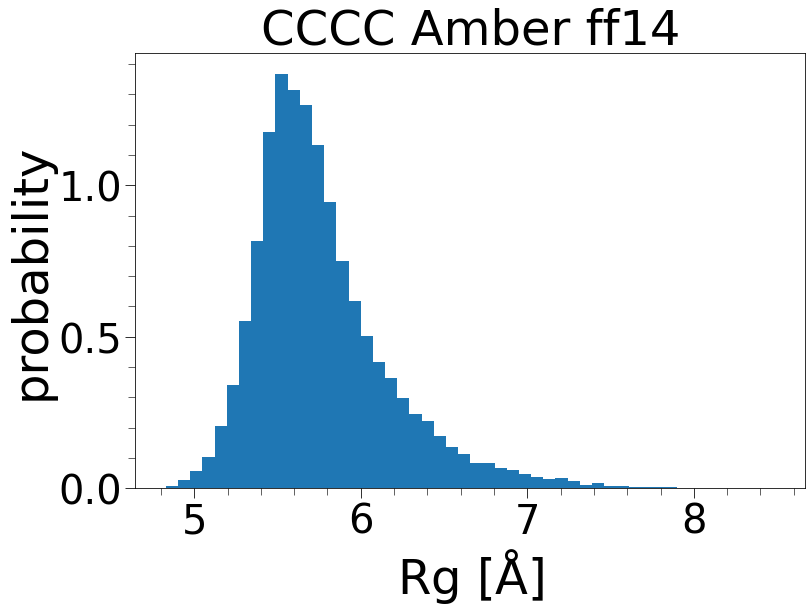

In [114]:
# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Rg [${\rm \AA}$]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.set_xlim([]) 

# y-axis
ax.set_ylabel('probability')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_ylim([])

# plot
ax.hist(rg, bins=50, density=True)

#plt.show()
plt.savefig("rg_hist.png")

#### Rg time plot

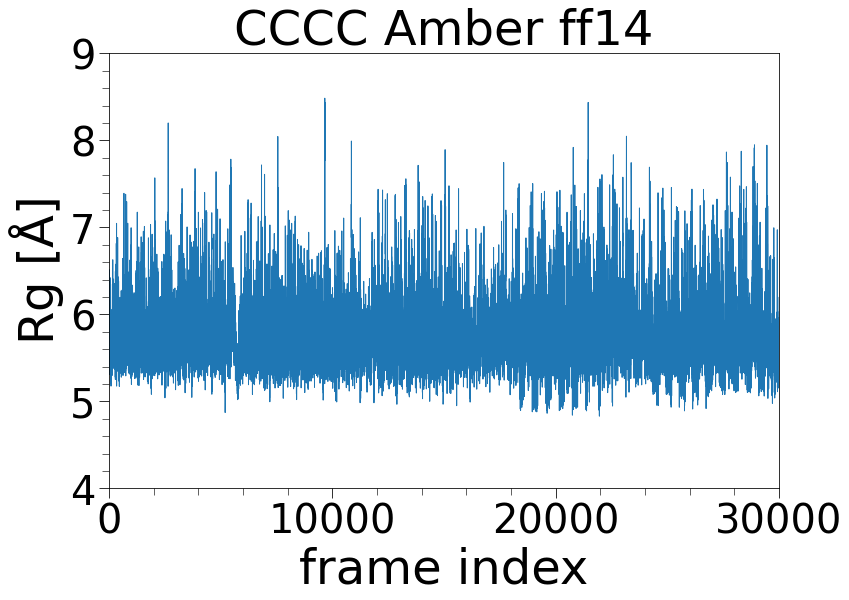

In [126]:
x = np.arange(len(rg))

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'frame index')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'Rg [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([int(rg.min()-0.5), int(rg.max()+1)])

# plot
ax.plot(x, rg, lw=1)

#plt.show()
plt.savefig("rg.png")

# RMSD and eRMSD

RMSD:  Calculate rmsd after optimal alignment between reference and target structures. Superposition and RMSD calculations are performed using all heavy atoms. If the sequence of reference and target is different, only backbone/sugar heavy atoms are used.  
eRMSD: Calculate ermsd between reference and target structures  

In [127]:
print(rmsd.max(), rmsd.min())
print(ermsd.max(), ermsd.min())

5.6749177 0.44833514
17.415346269144244 1.784354824721013


#### RMSD/eRMSD histogram

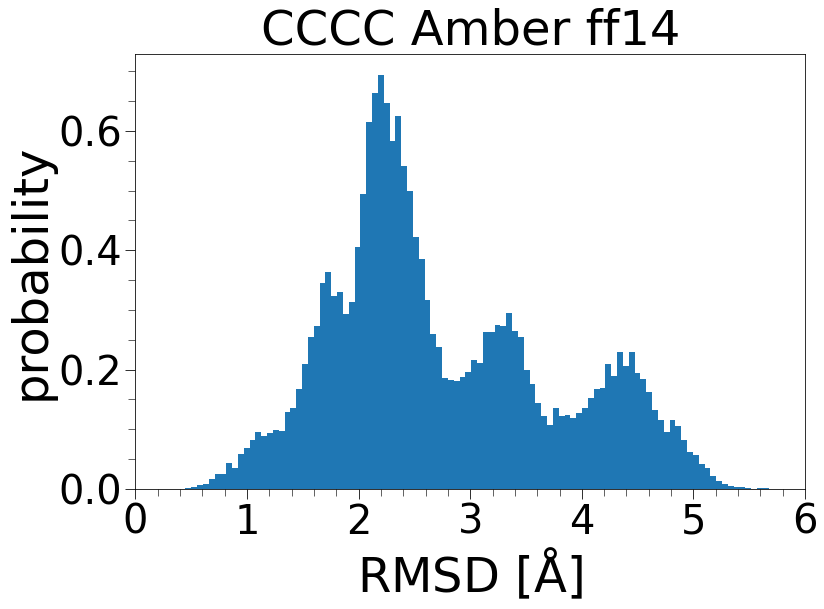

In [152]:
# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'RMSD [${\rm \AA}$]')
ax.xaxis.set_ticks(np.arange(0, 6.1, 1))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, int(rmsd.max()+1)]) 

# y-axis
ax.set_ylabel('probability')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_ylim([])

# plot
ax.hist(rmsd, bins=100, density=True)

#plt.show()
plt.savefig("rmsd_hist.png")

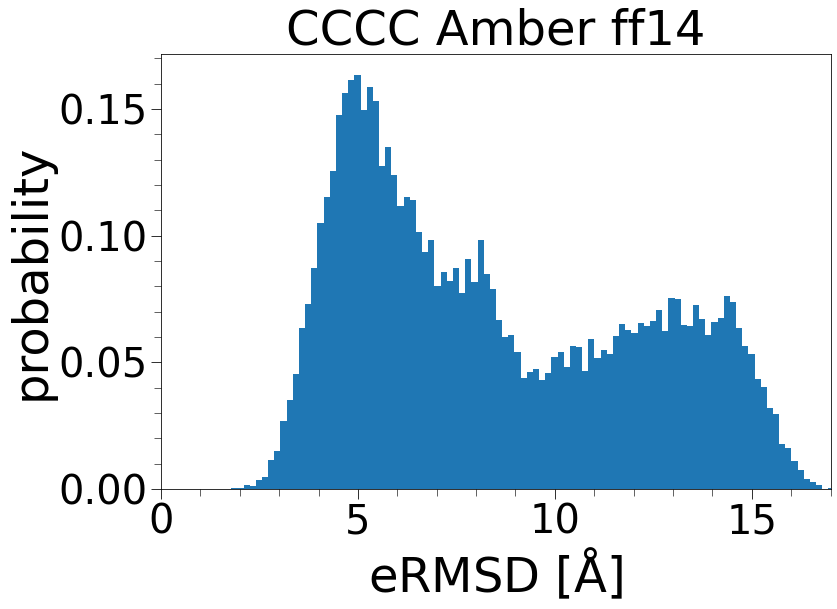

In [149]:
# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'eRMSD [${\rm \AA}$]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, int(ermsd.max()+0.5)]) 

# y-axis
ax.set_ylabel('probability')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_ylim([])

# plot
ax.hist(ermsd, bins=100, density=True)

#plt.show()
plt.savefig("ermsd_hist.png")

#### RMSD time plot

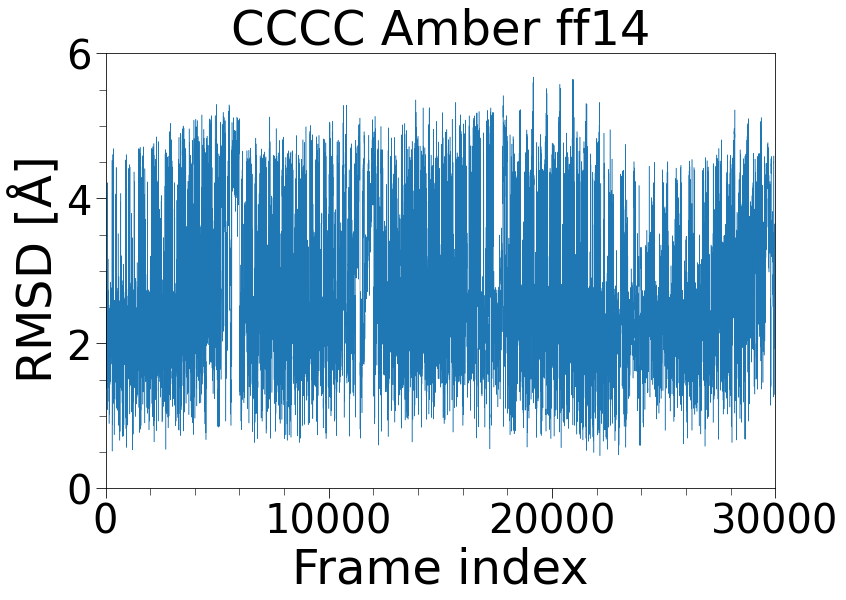

In [153]:
x = np.arange(len(rmsd))

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Frame index')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'RMSD [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([0, 6])

# plot
ax.plot(x, rmsd, lw=0.5)

#plt.show()
plt.savefig("rmsd.png")

#### eRMSD time plot

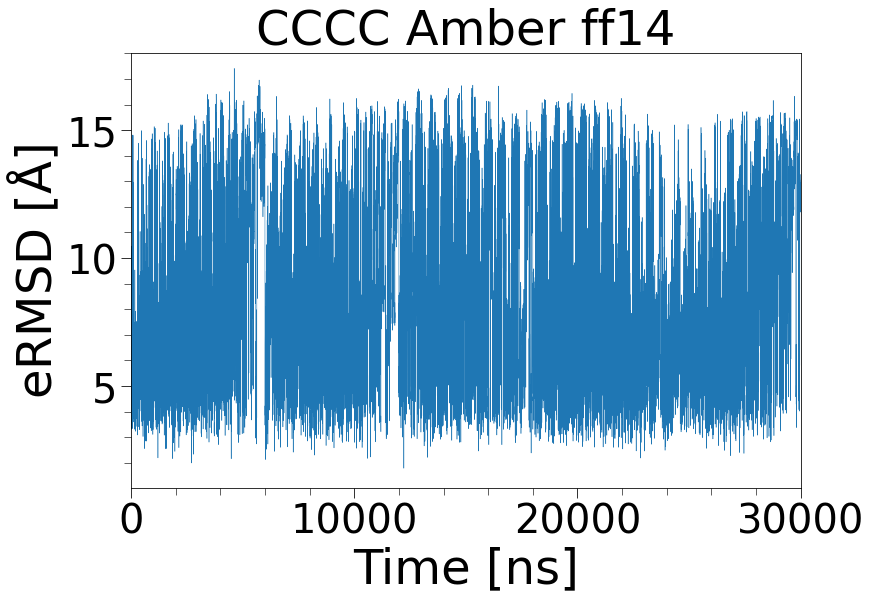

In [154]:
x = np.arange(len(ermsd))

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Time [ns]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'eRMSD [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([int(ermsd.min()-0.5), int(ermsd.max()+1)])

# plot
ax.plot(x, ermsd, lw=0.5)

#plt.show()
plt.savefig("ermsd.png")

#### RMSD and eRMSD side-by-side plot

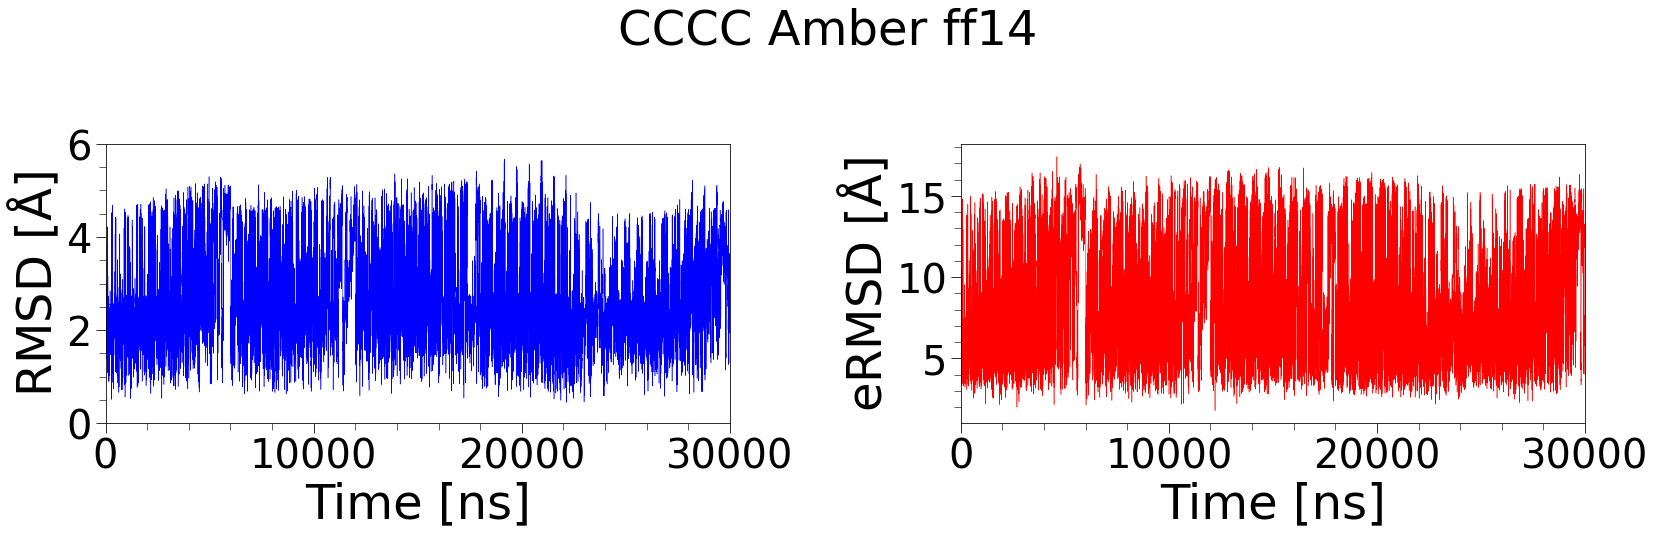

In [155]:
x = np.arange(len(ermsd))

# define
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 8))

# title
fig.suptitle(PLOT_TITLE)

# xy-axis (1)
ax1.set_xlabel(r'Time [ns]')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.set_xlim([0, len(x)]) 
ax1.set_ylabel(r'RMSD [${\rm \AA}$]')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim([0, 6])

# xy-axis (2)
ax2.set_xlabel(r'Time [ns]')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.set_xlim([0, len(x)]) 
ax2.set_ylabel(r'eRMSD [${\rm \AA}$]')
ax2.yaxis.set_minor_locator(AutoMinorLocator())
#ax2.set_ylim([0, 6])

# plot
ax1.plot(x, rmsd, lw=0.5, c='b')
ax2.plot(x, ermsd, lw=0.5, c='r')

plt.tight_layout()
#plt.show()
plt.savefig("rmsd_ermsd.png")

# Annotation ([srnas/barnaba/examples/example_03_annotate.ipynb](https://github.com/srnas/barnaba/blob/master/examples/example_03_annotate.ipynb))

`stackings, pairings, res = bb.annotate(pdb)`  

returns three lists:

- a list of stacking interactions
- a list of pairing interactions
- the list of residue names following the usual convention RESNAME_RESNUMBER_CHAININDEX

`stackings` and `pairings` contain the list of interactions for the N frames in the PDB/trajectory file and it is organized in the following way: for a given frame there are interactions between residues with index pairings`[i][0][k][0]` and `pairings[i][0][k][1]`. The type of interaction is specified at the element `pairings[i][1][k]`.

### Decypher the annotation  ###
Base-pairing are classified according to the Leontis-Westhof classification, where 
- W = Watson-Crick edge
- H = Hoogsteeen edge 
- S= Sugar edge
- c/t = cis/trans
- XXx = when two bases are close in space, but they do not fall in any of the categories. This happens frequently for low-resolution structures or from molecular simulations.

WWc pairs between complementary bases are called WCc or GUc.  
Stacking are classified according to the MCannotate classification:
- ">>" Upward
- "<<" Downward 
- "<>" Outward
- "><" Inward



### Criteria for stacking/pairing ###
First, we consider only bases that are "close" in space, i.e. $R_{ij} < 1.7$ and $R_{ji} < 1.7$.  
$R_{ij} = (x_{ij}/5, y_{ij}/5, z_{ij}/3)$ is the SCALED position vector with components ${x,y,z}$ (in $\mathring{A}$) of base j constructed on base i.  
The criteria for *base-stacking* are the following:

$( |z_{ij}| \; AND \; |z_{ji}| > 2 \mathring{A} ) \; AND \;  
(\rho_{ij} \; OR\; \rho_{ji} < 2.5 \mathring{A}) \; AND\;  
(|\theta_{ij}| < 40^{\circ} ) $ 

where
- $ \rho_{ij} = \sqrt{x_{ij}^2 + y_{ij}^2} $  
- $\theta_{ij}$ = angle between the vectors normal to the base plane

The criteria for *base-pairing* are the following:  

non stacked AND $|\theta_{ij}| < 60^{\circ}$ AND (number of hydrogen bonds $> 0$)  
The number of hydrogen bonds is calculated as the number of donor-acceptor pairs with distance $< 3.3 \mathring{A}$. 
If bases are complementary and the number of hydrogen bonds is > 1 (AU/GU) or > 2 (GC), the pair is considered WCc (or GUc).

- cis/trans is calculated according to the value of the dihedral angle defined by $C1'_{i}-N1/N9_{i}-N1/N9_{j}-C1'_{j}$
- edges are definded according to the value of $\psi = \arctan{(\hat{y}_{ij}/\hat{x}_{ij})}$. 
    1. Watson-Crick edge: $0.16 <\psi \le 2.0 rad$ 
    2. Hoogsteen edge:  $2.0 <\psi \le 4.0 rad $. 
    3. Sugar edge: $\psi > 4.0, \psi \le 0.16$

    
**ATT!**
- These criteria are slightly different from the one used in other popular software for annotating three-dimensional structures (e.g. X3DNA, MCAnnotate, Fr3D, etc.). From my experience, all these packages give slightly different results, especially for non-Watson-Crick base-pairs.
- Stacking is also problematic, as it relies on arbitrary criteria.
- In all cases, criteria for stacking and pairing were calibrated to work well for high resolution structures. These criteria might not be optimal for low-resolution structures and to describe nearly-formed interactions such the ones that are often encountered in molecular simulations.

### Dot-bracket annotation ###

From the list of base-pairing, we can obtain the dot-bracket annotation using the function
```python
dotbracket = bb.dot_bracket(pairings,res)
```
this function returns a string for each frame in the PDB/simulation. Let's see this in action:


### Symbols for base stacking from François Major’s group ([RNA 3D Structure Course](https://docs.google.com/document/d/173tvcKJgAUmjd03zIKLz-_KCNTlcHBNDWlDfDtMhxmU/edit#) by Craig L. Zirbel and Neocles Leontis at Bowling Green State Universtiy)

Two possible orientations of two stacked bases result in four base-stacking types: upward (>>), downward (<<), outward (<>) and inward (><). Two arrows pointing in the same direction (upward and downward) corresponds to the stacking type in the canonical A-RNA double-helix. Upward or downward is chosen depending on which base is referred first (i.e. A>>B means B is stacked upward of A, or A is stacked downward of B). The two other types are less frequent in RNAs, respectively inward (A><B; A or B is stacked inward of, respectively B or A) and outward (A<>B; A or B is stacked outward of, respectively B or A). 

#### check distance distribution

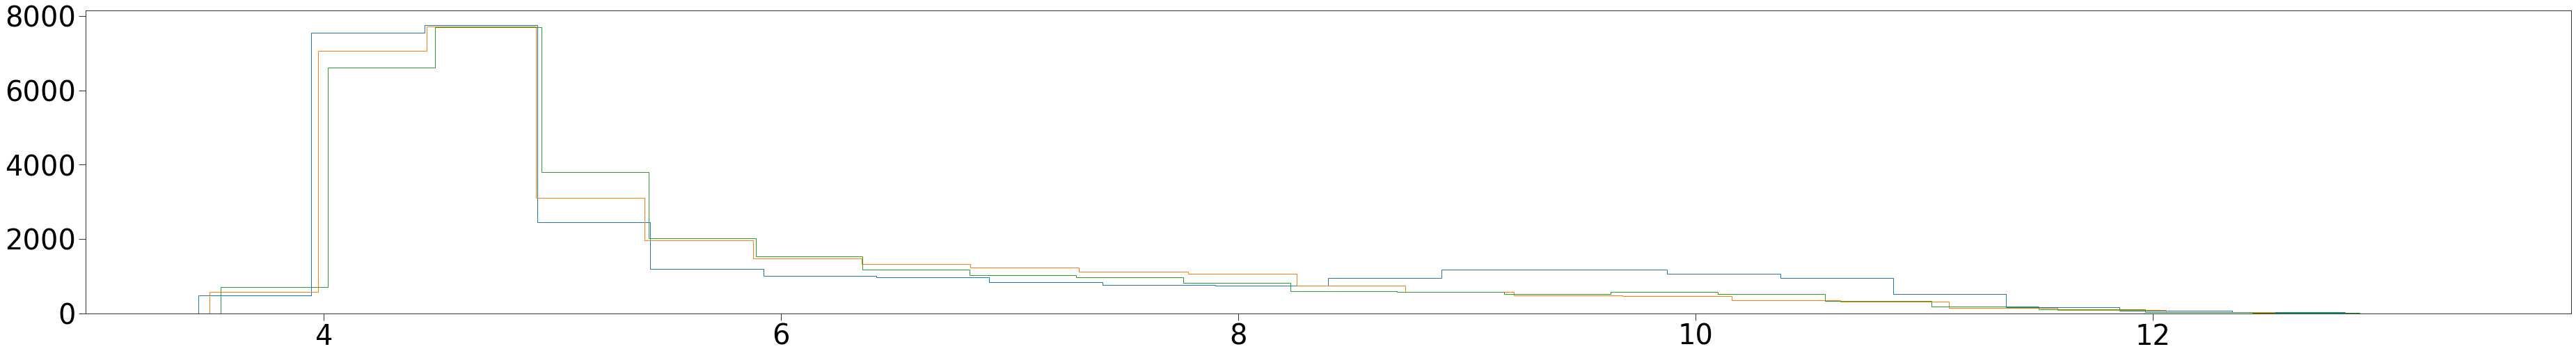

In [159]:
plt.hist(dist1, bins=20, histtype='step')
plt.hist(dist2, bins=20, histtype='step')
plt.hist(dist3, bins=20, histtype='step')
plt.show()

In [160]:
for i, v in enumerate(dist1):
    if v > 7.0:
        print(i+1, v)

24 [9.018866]
26 [8.226203]
27 [8.182555]
28 [8.03897]
65 [7.000681]
66 [7.2598333]
67 [7.0178657]
82 [7.5235767]
83 [7.304823]
86 [7.5954814]
114 [8.734196]
172 [7.4965544]
191 [8.478871]
192 [8.544096]
193 [7.228203]
195 [8.214139]
197 [9.386941]
200 [9.224737]
202 [9.151]
203 [10.410432]
205 [10.240999]
239 [8.584193]
279 [8.655174]
280 [8.778965]
290 [9.873254]
291 [9.355201]
292 [9.955368]
293 [9.663826]
294 [7.6931505]
329 [11.942074]
340 [8.254339]
342 [7.217701]
343 [7.8297806]
344 [8.547229]
346 [8.602237]
347 [9.46298]
348 [8.07622]
409 [7.090941]
451 [9.304627]
452 [9.189034]
460 [10.342631]
462 [8.585911]
463 [8.989081]
464 [9.600794]
465 [9.809334]
467 [8.03082]
470 [7.3476624]
475 [11.293584]
476 [11.725682]
477 [10.639225]
478 [11.322491]
490 [7.7738376]
501 [10.756698]
599 [7.7602887]
625 [8.724673]
629 [7.726045]
669 [7.0654635]
670 [7.4574943]
673 [7.8632045]
674 [7.8727207]
685 [8.755128]
699 [7.2263436]
705 [7.332906]
710 [9.695045]
713 [7.3797016]
715 [9.760886]
71

#### define individual angles

In [161]:
alpha = bb_angles[:,:,0]
beta = bb_angles[:,:,1]
gamma = bb_angles[:,:,2]
delta = bb_angles[:,:,3]
eps = bb_angles[:,:,4]
zeta = bb_angles[:,:,5]
chi = bb_angles[:,:,6]
phase = pucker_angles[:,:,0]

#### base stacking reference
https://pubs.acs.org/doi/full/10.1021/acs.jcim.0c01225

In [267]:
myclass = []
flipping_cutoff = 7

for frame_idx in range(len(stackings)):
    """
    stackings[frame_idx] : list
        e.g. [[[0, 1], [1, 2], [2, 3]], ['>>', '>>', '>>']]
    """
    stacking_residue_index = stackings[frame_idx][0]
    stacking_pattern = stackings[frame_idx][1]
        
        
    # 1) Define c3'-endo and c2'-endo using δ torsion angles
    #    C3'-endo: an individual ribose with δ between 55° and 110°
    #    C2'-endo: an individual ribose with δ between 120° and 175°
    #    Ref: RNA backbone: Consensus all-angle conformers and modular string nomenclature (an RNA Ontology Consortium contribution), RNA 2008
    # 2) Define by pucker phase angle: C3' -endo [0°, 36°) as in canonical RNA and A-form DNA, and the C2'-endo [144°, 180°)
    c3_endo, c2_endo = [], []
    for _delta, _phase in zip(delta[frame_idx], phase[frame_idx]):
        if (_delta >= 55 and _delta < 110) or (_phase >=0 and _phase < 36):
            c3_endo.append(1)
        else:
            c3_endo.append(0)
        if (_delta >= 120 and _delta < 175) or (_phase >= 144 and _phase < 180):
            c2_endo.append(1)
        else:
            c2_endo.append(0)


    name = ""
    
    #
    # A-form
    #
    if len(stacking_pattern) == 3 and sum(c3_endo) == len(rnames):
    #if stacking_pattern == ['>>', '>>', '>>']:
    #if stacking_pattern == ['>>', '>>', '>>'] and sum(c3_endo) == len(rnames):
        # AMa: A-form major (3'-end backbone gamma-torsion +gauche)
        if gamma[frame_idx, -1] >= 30 and gamma[frame_idx, -1] < 90:
            name = "AMa"
            
        # AMi: A-form minor (3'-end backbone gamma-torsion is trans)
        if gamma[frame_idx, -1] >= 150 and gamma[frame_idx, -1] < 210:    
            name = "AMi"

    # Alternative:
    # Use nomenclature definition 1a (delta-epsilon-zeta: 3'-em and alpha-beta-gamma-delta: mtp3') from 
    # Ref: RNA backbone: Consensus all-angle conformers and modular string nomenclature (an RNA Ontology Consortium contribution), RNA 2008
    #
    # 3': delta 55 to 110
    # -e: -120 +- 25 (A-?) -> 215 to 265
    # m: -60 (gauche-) -> 270 to 330
    # t: 180 (T) -> 150 to 210
    # p: 60 (gauche+) -> 30 to 90
    # e: 120 +- 25 (A+) -> 95 to 145
    
    count = 0
    # delta (C3'-endo): i+1, i+2, i+3, i+4 -> 3'
    if sum(c3_endo) == len(rnames):
        count+=1
    # epsilon (i, i+1, i+2) -> -e
    if np.all(np.logical_and(eps[frame_idx][:len(eps[frame_idx])-1] >= 215, eps[frame_idx][:len(eps[frame_idx])-1] < 265)):
        count+=1
    # zeta (i, i+1, i+2) -> m
    if np.all(np.logical_and(zeta[frame_idx][:len(zeta[frame_idx])-1] >= 270, zeta[frame_idx][:len(zeta[frame_idx])-1] < 330)):
        count+=1
    # alpha (i+1, i+2, i+3) -> m
    if np.all(np.logical_and(alpha[frame_idx][1:] >= 270, alpha[frame_idx][1:] < 330)):
        count+=1
    # beta (i+1, i+2, i+3) -> t
    if np.all(np.logical_and(beta[frame_idx][1:] >= 150, beta[frame_idx][1:] < 210)):
        count+=1
    # gamma (i, i+1, i+2, i+3) -> p
    if np.all(np.logical_and(beta[frame_idx] >= 30, beta[frame_idx] < 90)):
        count+=1

    if count == 6:
        # AMa: A-form major (3'-end backbone gamma-torsion +gauche)
        if gamma[frame_idx, -1] >= 30 and gamma[frame_idx, -1] < 90:
            name = "AMa-"
            
        # AMi: A-form minor (3'-end backbone gamma-torsion is trans)
        if gamma[frame_idx, -1] >= 150 and gamma[frame_idx, -1] < 210:    
            name = "AMi-"
    
    #
    # I: Intercaleted (nucleotide j inserts between and stacks against nb i and i+1)            
    #
    # check if stacking residues are from i and i+1
    # exclude stacking_residue_index=[0, 3] (i.e., 5'- and 3'-end stacking )
    # exclude stacking_residue_index=[0, 2]
    #if ([1, 3] in stacking_residue_index and [1, 2] in stacking_residue_index):
    if [0, 1] in stacking_residue_index and [0, 2] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I1".format(frame_idx+1, name))
        name = "I1"
    if [0, 2] in stacking_residue_index and [0, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I2".format(frame_idx+1, name))
        name = "I2"
    if [1, 2] in stacking_residue_index and [1, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I3".format(frame_idx+1, name))
        name = "I3"
    if [0, 2] in stacking_residue_index and [1, 2] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I4".format(frame_idx+1, name))
        name = "I4"
    if [0, 3] in stacking_residue_index and [1, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I5".format(frame_idx+1, name))
        name = "I5"
    if [1, 3] in stacking_residue_index and [2, 3] in stacking_residue_index:
        if name != "":
            print("{}: overwrite {} to I6".format(frame_idx+1, name))
        name = "I6"

        
    #          
    # Base flipping (distance, 
    # https://pubs.acs.org/doi/10.1021/acs.jpcb.2c00340
    #
    
    # F1: Nucleotide-1 flipped (ribose ring of the terminal nucleotide adopts the C2'-endo configuration and the base is flipped away from the other three)
    # 1) 5'-end is C2 endo
    # 2) Exlculde stacking_residue_index=[0,1] and confirm all other nb are stacking (i.e., stacking_pattern = ['>>', '>>'])
    # 3) N1 distance between first and second nb is greater than flippling_dist_cutoff
    if c2_endo[0] == 1 and [0, 1] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist1[frame_idx] > flipping_dist_cutoff:
    #if [0, 1] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist1[frame_idx] > flipping_cutoff:
        if name != "":
            print("{}: overwrite {} to F1".format(frame_idx+1, name))
        name = "F1"

    #if c2_endo[1] == 1 and [1, 2] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist1[frame_idx] > flipping_dist_cutoff and dist2[frame_idx] > flipping_distance:
    #if [1, 2] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist1[frame_idx] > flipping_cutoff and dist2[frame_idx] > flipping_cutoff:
    #    if name != "":
    #        print("{}: overwrite {} to F2".format(frame_idx+1, name))
    #    name = "F2"        
        
    #if c2_endo[2] == 1 and [2, 3] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist2[frame_idx] > flipping_dist_cutoff and dist3[frame_idx] > flipping_distance:
    #if [2, 3] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist2[frame_idx] > flipping_cutoff and dist3[frame_idx] > flipping_cutoff:
    #    if name != "":
    #        print("{}: overwrite {} to F3".format(frame_idx+1, name))
    #    name = "F3"                
        
    if c2_endo[-1] == 1 and [2, 3] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist3[frame_idx] > flipping_dist_cutoff:
    #if [2, 3] not in stacking_residue_index and stacking_pattern == ['>>', '>>'] and dist3[frame_idx] > flipping_cutoff:
        if name != "":
            print("{}: overwrite {} to F4".format(frame_idx+1, name))        
        name = "F4"

        
        
    #
    # O: Others (all others)
    #
    if name == "":
        name = "O"
    
    
    
    myclass.append(name)
    #print(frame_idx+1, name, stacking_residue_index, stacking_pattern, pairing_residue_index, pairing_pattern, phase[i,:], delta[i,:], gamma[i,:])
    #print(frame_idx+1, name)
    #print(stacking_residue_index, stacking_pattern)
    #print(list(alpha[frame_idx,:]), list(beta[frame_idx,:]), list(gamma[frame_idx,:]), list(delta[frame_idx,:]), list(eps[frame_idx,:]), list(zeta[frame_idx,:]), list(phase[frame_idx,:]), dist1[frame_idx], dist2[frame_idx], dist3[frame_idx], c3_endo, c2_endo)
    with open("log.txt", "a") as wf:
        wf.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(frame_idx+1, 
                                                                                               name, 
                                                                                               stacking_residue_index, 
                                                                                               stacking_pattern, 
                                                                                               list(alpha[frame_idx,:]), 
                                                                                               list(beta[frame_idx,:]), 
                                                                                               list(gamma[frame_idx,:]), 
                                                                                               list(delta[frame_idx,:]), 
                                                                                               list(eps[frame_idx,:]), 
                                                                                               list(zeta[frame_idx,:]), 
                                                                                               list(phase[frame_idx,:]), 
                                                                                               dist1[frame_idx], 
                                                                                               dist2[frame_idx], 
                                                                                               dist3[frame_idx], 
                                                                                               c3_endo, 
                                                                                               c2_endo))

3715: overwrite I2 to I4
12754: overwrite I2 to I4
12763: overwrite I2 to I4
13362: overwrite I2 to I4
15299: overwrite I2 to I4
19923: overwrite AMa to I6
27412: overwrite F1 to F4
27413: overwrite F1 to F4
28043: overwrite F1 to F4
28045: overwrite F1 to F4
28625: overwrite F1 to F4
28633: overwrite F1 to F4
28638: overwrite F1 to F4
28649: overwrite F1 to F4
28650: overwrite F1 to F4
28694: overwrite F1 to F4
29203: overwrite F1 to F4
29229: overwrite F1 to F4
29252: overwrite F1 to F4
29286: overwrite F1 to F4
29362: overwrite F1 to F4
29959: overwrite F1 to F4
29960: overwrite F1 to F4
29961: overwrite F1 to F4
29964: overwrite F1 to F4
29965: overwrite F1 to F4
29971: overwrite F1 to F4
29978: overwrite F1 to F4
29979: overwrite F1 to F4
29981: overwrite F1 to F4
29983: overwrite F1 to F4
29987: overwrite F1 to F4
29993: overwrite F1 to F4
29994: overwrite F1 to F4
29999: overwrite F1 to F4
30000: overwrite F1 to F4


In [268]:
print(len(myclass))

30000


In [269]:
from collections import Counter
d = Counter(myclass)

mydata = {
    "AMa":  d["AMa"], \
    "AMa-": d["AMa-"], \
    "AMi":  d["AMi"], \
    "AMi-": d["AMi-"], \
    "I1":   d["I1"], \
    "I2":   d["I2"], \
    "I3":   d["I3"], \
    "I4":   d["I4"], \
    "I5":   d["I5"], \
    "I6":   d["I6"], \
    "F1":   d["F1"], \
    "F2":   d["F2"], \
    "F3":   d["F3"], \
    "F4":   d["F4"], \
    "O":    d["O"]
}
mydata

{'AMa': 5365,
 'AMa-': 0,
 'AMi': 12,
 'AMi-': 0,
 'I1': 1,
 'I2': 293,
 'I3': 0,
 'I4': 65,
 'I5': 0,
 'I6': 2,
 'F1': 259,
 'F2': 0,
 'F3': 0,
 'F4': 442,
 'O': 23561}

In [270]:
mydata = {
    "AMa": 100*(d["AMa"]+d["AMa-"])/len(myclass), \
    "AMi": 100*(d["AMi"]+d["AMi-"])/len(myclass), \
    "I":   100*(d["I1"]+d["I2"]+d["I3"]+d["I4"]+d["I5"]+d["I6"])/len(myclass), \
    "F1":  100*d["F1"]/len(myclass), \
    "F4":  100*d["F4"]/len(myclass), \
    "O":   100*d["O"]/len(myclass)
}

mycolor = ["green", "blue", "red", "magenta", "orange", "black"]

In [271]:
mydata

{'AMa': 17.883333333333333,
 'AMi': 0.04,
 'I': 1.2033333333333334,
 'F1': 0.8633333333333333,
 'F4': 1.4733333333333334,
 'O': 78.53666666666666}

In [272]:
# rmsd scatter plot
color = []
for _ in myclass:
    if _ == "AMa":
        color.append("green")
    elif _ == "AMi":
        color.append("blue")
    elif _ in ["I1", "I2", "I3", "I4", "I5", "I6"]:
        color.append("red")
    elif _ in "F1":
        color.append("magenta")
    elif _ == "F4":
        color.append("orange")
    elif _ == "O":
        color.append("black")
    else:
        print("undefined {}".format(_))
        color.append("white")

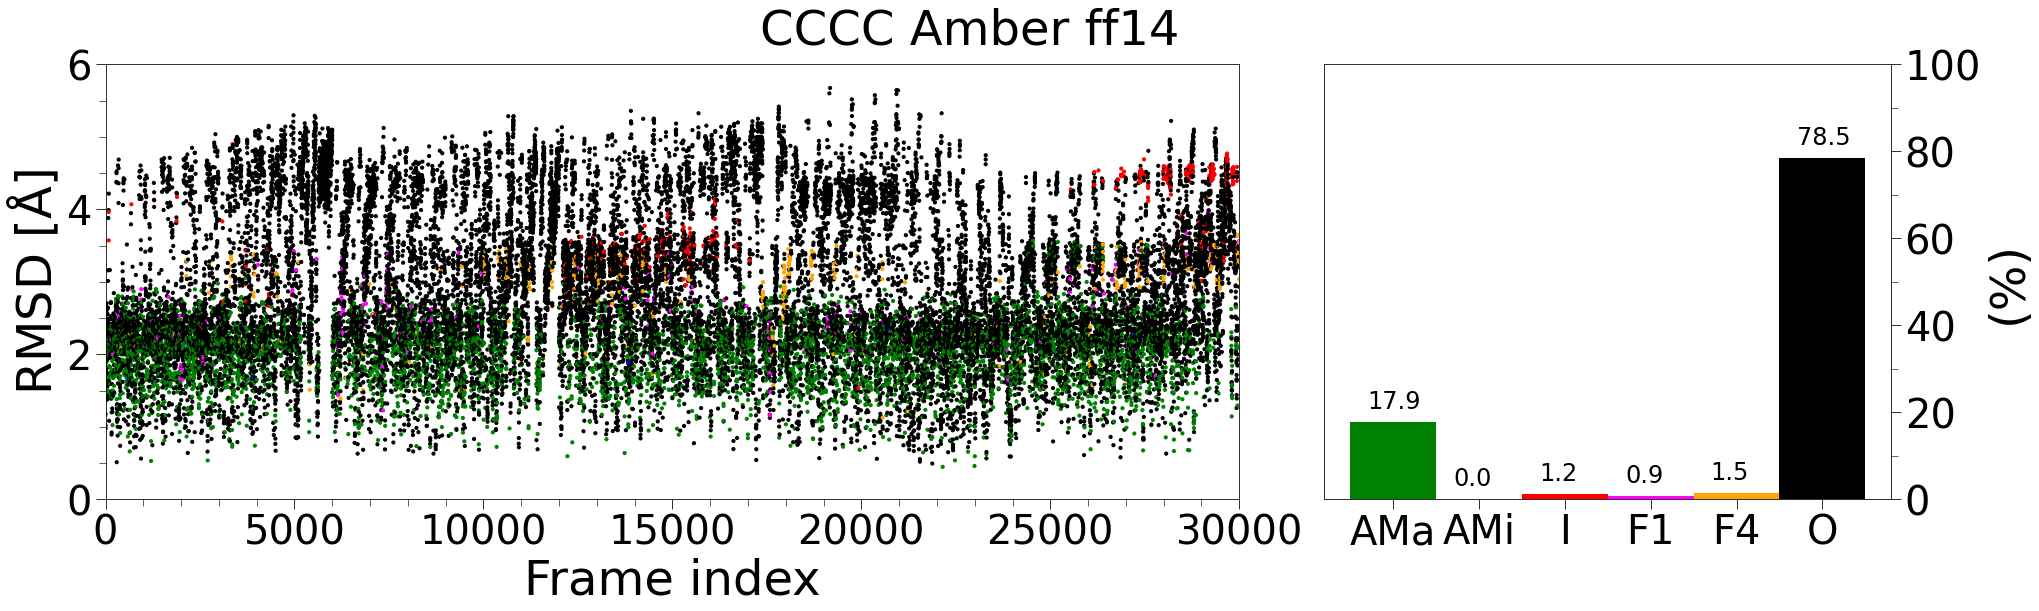

In [278]:
# define
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32, 8), gridspec_kw={'width_ratios': [2, 1]})

# title
fig.suptitle(PLOT_TITLE)

# xy-axis (1)
ax1.set_xlabel(r'Frame index')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.set_xlim([0, len(rmsd)]) 
ax1.set_ylabel(r'RMSD [${\rm \AA}$]')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim([0, 6])

# xy-axis (2)
#ax2.set_xlabel(r'')
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax2.set_xlim([0, len(x)]) 
ax2.set_ylabel('(%)')
ax2.yaxis.set_label_position("right")
#ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(MultipleLocator(10))
ax2.yaxis.set_ticks_position("right")
ax2.set_ylim([0, 100])

i = 0
for k, v in mydata.items():
    ax2.text(x=i-0.3, y=v+3, s=f'{v:.1f}', size=24)
    i += 1


# plot
x = np.arange(len(rmsd))
ax1.scatter(x, rmsd, color=color, s=10)
ax2.bar(mydata.keys(), mydata.values(), width=1, color=mycolor)


#plt.subplots_adjust(left=0.1,
#                    bottom=0.1, 
#                    right=0.9, 
#                    top=0.9, 
#                    wspace=0.4, 
#                    hspace=0.4)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
#plt.show()
plt.savefig("rmsd_conformation_population.png")

# J-Coupling

In [274]:
mydict={}
mydict["H1H2"] = "nu1"
mydict["H2H3"] = "nu2"
mydict["H3H4"] = "nu3"
mydict["1H5P"] = "beta1"
mydict["2H5P"] = "beta2"
mydict["1H5H4"] = "gamma1"
mydict["2H5H4"] = "gamma2"
mydict["H3P"] = "epsilon"

#### average anconcatenatendard deviation

In [283]:
#v = []
#for i in range(couplings.shape[0]):
#    v.append(couplings[i,1,-1])   
#v = np.array(v)
#v.mean()

m = couplings.mean(axis=0)
s = couplings.std(axis=0)

In [284]:
pd.options.display.float_format = '{:.2f}'.format

df_m = pd.DataFrame(m, columns=list(mydict.values()))
df_s = pd.DataFrame(s, columns=list(mydict.values()))

In [285]:
df_m

,nu1,nu2,nu3,beta1,beta2,gamma1,gamma2,epsilon
0,3.35,5.23,8.66,NaN,NaN,3.13,3.09,8.33
1,4.18,5.45,7.55,4.39,2.61,1.99,1.99,8.40
2,3.65,5.60,8.08,4.60,2.50,2.04,1.96,7.93
3,5.50,5.85,6.08,4.01,2.87,2.07,2.01,NaN


In [286]:
df_s

,nu1,nu2,nu3,beta1,beta2,gamma1,gamma2,epsilon
0,3.58,1.44,3.29,NaN,NaN,3.47,3.56,2.36
1,3.87,1.41,3.84,2.59,2.57,1.71,2.20,2.50
2,3.50,1.36,3.37,2.61,2.37,1.74,2.25,2.64
3,3.88,1.25,3.99,2.56,2.61,2.02,2.12,NaN


# J-Coupling (Bayesian inference)

In [ ]:
#Import required packages
import pymc3 as pm
import arviz as az

In [ ]:
couplings[:,0,-1].shape

In [ ]:
#tosses = [ 0,0,0,0,0,0,0,0,0,1]

#couplings: (frame idx, residue, jcoupling values)
tosses = couplings[:,3,0]
tosses

In [ ]:
df_m["nu1"][3]

In [ ]:
with pm.Model() as model:
    # lets define the prior
    #hypo = pm.Beta('hypo', 2, 2)
    #hypo = pm.Normal('hypo', mu=df_m["nu1"][3], sigma=df_s["nu1"][3])
    hypo = pm.Gamma('hypo', mu=df_m["nu1"][3], sigma=df_s["nu1"][3])
    
    # define probability
    #data = pm.Bernoulli('data', hypo, observed=tosses)
    #data = pm.Normal('data', hypo, observed=tosses)
    data = pm.Poisson('data', hypo, observed=tosses)
    
    # sample
    trace = pm.sample(return_inferencedata=True)

In [ ]:
data

In [ ]:
trace

In [ ]:
# visualize
az.plot_posterior(trace, hdi_prob=0.95)